In [1]:
import tensorflow as tf
from PARCv2.PARC.model.model_em_adaptive import PARCv2 as parc_ml
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

2024-07-11 12:51:29.636513: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 12:51:37.437088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46589 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


### Train

In [2]:
parc_ml_test = parc_ml(3, 1, 1.0/60, (64, 64))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)
parc_ml_test.differentiator.load_weights("PARC2_JACK_diff_rk4_800.h5")
parc_ml_test.compile(optimizer)

In [3]:
train_data = np.load("concatenated_array.npy")[:, 40:104, :64, :]
features = (train_data[:, :, :, :3], train_data[:, :, :, 6:8])
features_dataset = tf.data.Dataset.from_tensor_slices(features)
labels = (train_data[:, :, :, 3:6], train_data[:, :, :, 8:])
labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
train_dataset = tf.data.Dataset.zip((features_dataset, labels_dataset))
train_dataset = train_dataset.shuffle(buffer_size=2192).batch(1)

In [ ]:
parc_ml_test.fit(train_dataset, epochs=20, shuffle=True)
parc_ml_test.differentiator.save_weights("PARC2_EMA_diff_dp_20.h5")

Epoch 1/20
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2024-07-11 12:54:22.378757: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/dormand_prince/while/body/_632/dormand_prince/while/advance_to_solution_time/while/exit/_15978' -> 'StatefulPartitionedCall/dormand_prince/while/body/_632/dormand_prince/while/advance_to_solution_time/while/LoopExecuted/_16043', 'StatefulPartitionedCall/dormand_prince/while/body/_632/dormand_prince/while/Identity_3' -> 'StatefulPartitionedCall/dormand_prince/while/next_iteration/_1103', 'StatefulPartitionedCall/dormand_prince/while/body/_632/dormand_prince/while/advance_to_solution_time/while/exit/_15987' -> 'StatefulPartitionedCall/dormand_prince/while/body/_632/dormand_prince/while/advance_to_solution_time/while/LoopExecuted/_16043', 'StatefulPartitionedCall/dormand_prince/while/body/_632/dormand_prince/while/Identity_12' -> 'StatefulPartitionedCall/dormand_pri

59/59 [==============================] - 859s 11s/step - total_loss: 19.4154
Epoch 2/20
29/59 [=============>................] - ETA: 7:04 - total_loss: 18.1007

### Inference

In [3]:
parc_ml_test = parc_ml(3, 60, 1.0/60, (64, 64))
parc_ml_test.differentiator.load_weights("PARC2_JACK_diff_rk4_800.h5")
parc_ml_test.compile()

In [4]:
test_data = np.load("concatenated_array.npy")[:, 40:104, :64, :]
ic = (test_data[0:1, :, :, :3], test_data[0:1, :, :, 6:8])
sim = parc_ml_test(ic, [1.0/60, 2.0/60, 3.0/60, 4.0/60, 5.0/60])

2024-07-11 09:53:58.327562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-07-11 09:53:59.356055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [6]:
sim.diagnostics

_DopriDiagnostics(num_ode_fn_evaluations=<tf.Tensor: shape=(), dtype=int32, numpy=624>, num_jacobian_evaluations=<tf.Tensor: shape=(), dtype=int32, numpy=0>, num_matrix_factorizations=<tf.Tensor: shape=(), dtype=int32, numpy=0>, status=<tf.Tensor: shape=(), dtype=int32, numpy=0>)

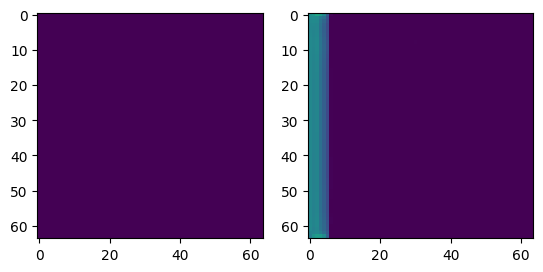

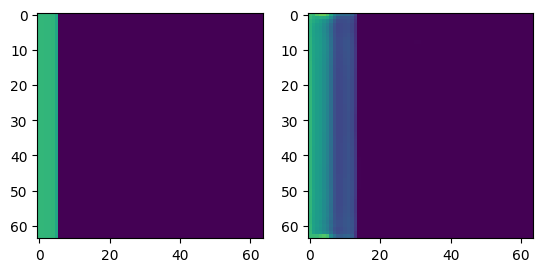

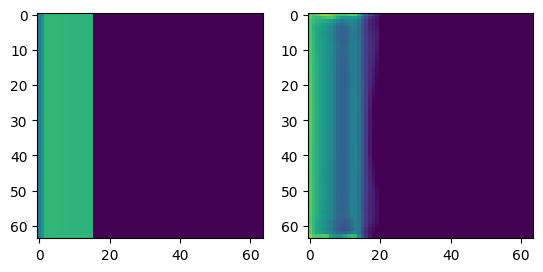

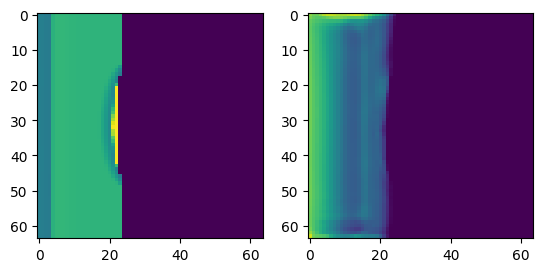

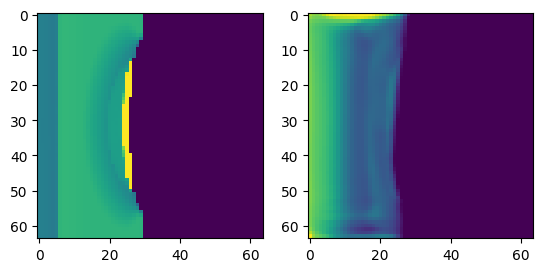

In [8]:
for i in range(5):
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.imshow(test_data[i, :, :, 0], vmin=0.0, vmax=0.1)
    ax1.imshow(sim.states[i, 0, :, :, 0], vmin=0.0, vmax=0.1)